## FULL PROJECT PIPELINE
1. Install required libraries and input your chosen file
2. Run term frequency and sentiment analysis
3. Save output with all changes
4. Input the outputted file
5. Run Topic Modeling Prep and decide how many topics you'd like for your model
6. Run topic modeling & sentiment comparison
7. Run Final Summary
8. Choose visualizations






#INSTALL REQUIRED LIBRARIES

In [ ]:
# STEP 1: Install Required Libraries
# Run this cell ONCE, then follow the instructions below

print("📦 Installing dependencies (this takes ~30 seconds)...")
print("=" * 60)

# Uninstall conflicting packages
!pip uninstall -y numpy pandas scipy

# Install compatible versions together
!pip install -q numpy==1.26.4 pandas==2.2.2 scipy==1.13.1

# Install gensim and nltk
!pip install -q gensim==4.3.3 nltk

print("\n" + "=" * 60)
print("✅ Installation complete!")
print("=" * 60)
print("\n🔄 🔄 🔄 STOP! MANDATORY NEXT STEP 🔄 🔄 🔄")
print("\nYou MUST restart the runtime before continuing:")
print("   1. Click 'Runtime' in the menu bar above")
print("   2. Select 'Restart session'")
print("   3. When prompted, click 'Yes' to confirm")
print("   4. Then run the NEXT cell to import libraries")
print("\n⚠️  Do NOT skip this step or you will get errors!")
print("=" * 60)

📦 Installing dependencies (this takes ~30 seconds)...
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
o

In [ ]:
#Importing all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Display settings for better output
pd.options.display.max_rows = 20
pd.options.display.max_columns = 10

print("=" * 60)
print("✅ All libraries loaded and ready!")
print("=" * 60)
print(f"NumPy version: {np.__version__}")
print(f"Gensim version: {gensim.__version__}")

# Install and import VADER
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

print("✅ VADER installed and ready for sentiment analysis!")
print("📚 Libraries imported - ready for analysis!")

✅ All libraries loaded and ready!
NumPy version: 1.26.4
Gensim version: 4.3.3
✅ VADER installed and ready for sentiment analysis!
📚 Libraries imported - ready for analysis!


# INPUT YOUR FILE BELOW

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Scraped Episodes/ST_US_ALL_COMMENTS.csv')  # Replace with ALL_COMMENTS.csv for each show

df.info()

print("\n" + "="*50 + "\n")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      446 non-null    int64  
 1   Comment     446 non-null    object 
 2   Unnamed: 2  0 non-null      float64
 3   Unnamed: 3  0 non-null      float64
 4   Unnamed: 4  0 non-null      float64
 5   Unnamed: 5  0 non-null      float64
 6   Unnamed: 6  0 non-null      float64
 7   Unnamed: 7  1 non-null      float64
dtypes: float64(6), int64(1), object(1)
memory usage: 28.0+ KB




# TERM FREQUENCY/SENTIMENT ANALYSIS

In [ ]:
## FILE PREP/CLEANING

# stopwords list
stopwords = [
    # Basic stopwords from HW1
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is",
    "are", "was", "were", "be", "been", "being", "have", "has", "had", "having",
    "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or",
    "because", "as", "until", "while", "of", "at", "by", "for", "with", "about",
    "against", "between", "into", "through", "during", "before", "after", "above",
    "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under",
    "again", "further", "then", "once", "here", "there", "when", "where", "why",
    "how", "all", "any", "both", "each", "few", "more", "most", "other", "some",
    "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very",
    "s", "t", "can", "will", "just", "don", "should", "now", "ve", "ll", "amp",

    # Additional common words for cultural data
    "also", "would", "could", "get", "go", "one", "two", "see", "time", "way", "may",
    "said", "say", "new", "first", "last", "long", "little", "much", "well", "still","re","m"
]

print(f"✅ Stopwords list loaded: {len(stopwords)} words to filter out")
print()

# Text processing functions (building on HW1 approach)
def split_into_words(text):
    """Split text into words (same approach as HW1)"""
    if pd.isna(text):  # Handle missing text
        return []
    lowercase_text = str(text).lower()
    # Split text into words by looking for places where letters/numbers are not present
    split_words = re.split("\\W+", lowercase_text)
    return [word for word in split_words if word]  # Remove empty strings

def clean_for_sentiment(text):
    """Clean text for sentiment analysis (keep punctuation!)"""
    if pd.isna(text):
        return ""
    # Keep punctuation and capitalization - VADER needs them!
    return str(text).strip()
# Apply text cleaning to your dataset
# Replace 'text_column' with your actual column name
print("✅ Text cleaning complete")
print()

# Create cleaned text for sentiment analysis (keep punctuation)
df['clean_text_sentiment'] = df["Comment"].apply(clean_for_sentiment)

# Create word lists for term frequency analysis (like HW1)
df['words'] = df["Comment"].apply(split_into_words)
df['meaningful_words'] = df['words'].apply(lambda word_list: [word for word in word_list if word not in stopwords])

all_meaningful_words = []
for word_list in df['meaningful_words']:
    all_meaningful_words.extend(word_list)

word_frequency = Counter(all_meaningful_words)
top_words = word_frequency.most_common(20)  # Get top 20 words

print("🔤 TERM FREQUENCY ANALYSIS RESULTS")
print("=" * 40)
print(f"Total words analyzed: {len(all_meaningful_words):,}")
print(f"Unique words found: {len(word_frequency):,}")
print(f"\nTop 20 most frequent words:")

for i, (word, count) in enumerate(top_words, 1):
    print(f"{i:2d}. {word:<15} ({count:,} times)")

print()
print("✅ Term frequency complete")
print()
## SENTIMENT ANALYSIS

# Apply sentiment analysis to your entire dataset
def get_sentiment_score(text):
    """Get compound sentiment score for a text"""
    scores = analyzer.polarity_scores(text)
    return scores['compound']

df['sentiment_score'] = df['clean_text_sentiment'].apply(get_sentiment_score)
# Analyze sentiment patterns in your data
print("🎭 SENTIMENT ANALYSIS SUMMARY")
print("=" * 35)

# Basic statistics
print(f"Total entries analyzed: {len(df)}")
print(f"Average sentiment: {df['sentiment_score'].mean():.3f}")
print(f"Most positive entry: {df['sentiment_score'].max():.3f}")
print(f"Most negative entry: {df['sentiment_score'].min():.3f}")
print(f"Standard deviation: {df['sentiment_score'].std():.3f}")

# Categorize sentiments
positive = len(df[df['sentiment_score'] > 0.1])
neutral = len(df[(df['sentiment_score'] >= -0.1) & (df['sentiment_score'] <= 0.1)])
negative = len(df[df['sentiment_score'] < -0.1])

print(f"\nSentiment distribution:")
print(f"Positive (>0.1): {positive} ({positive/len(df)*100:.1f}%)")
print(f"Neutral (-0.1 to 0.1): {neutral} ({neutral/len(df)*100:.1f}%)")
print(f"Negative (<-0.1): {negative} ({negative/len(df)*100:.1f}%)")

most_positive = df.loc[df['sentiment_score'].idxmax()]
most_negative = df.loc[df['sentiment_score'].idxmin()]

print(f"📈 MOST POSITIVE ENTRY (score: {most_positive['sentiment_score']:.3f}):")
print(f"Text: {most_positive['clean_text_sentiment'][:200]}...")
print()
print(f"📉 MOST NEGATIVE ENTRY (score: {most_negative['sentiment_score']:.3f}):")
print(f"Text: {most_negative['clean_text_sentiment'][:200]}...")
print()
print("✅ Sentiment analysis complete")
print()
# Analyze word frequency in positive vs. negative entries
positive_entries = df[df['sentiment_score'] > 0.1]
negative_entries = df[df['sentiment_score'] < -0.1]

positive_words = []
for word_list in positive_entries['meaningful_words']:
    positive_words.extend(word_list)
positive_freq = Counter(positive_words)

negative_words = []
for word_list in negative_entries['meaningful_words']:
    negative_words.extend(word_list)
negative_freq = Counter(negative_words)



print(f"Top 10 words in POSITIVE entries ({len(positive_entries)} entries):")
for word, count in positive_freq.most_common(10):
    print(f"  {word:<15} ({count} times)")

print(f"\nTop 10 words in NEGATIVE entries ({len(negative_entries)} entries):")
for word, count in negative_freq.most_common(10):
    print(f"  {word:<15} ({count} times)")
print()
print("✅ Comparison analysis complete")

✅ Stopwords list loaded: 153 words to filter out

✅ Text cleaning complete

🔤 TERM FREQUENCY ANALYSIS RESULTS
Total words analyzed: 3,186
Unique words found: 1,437

Top 20 most frequent words:
 1. robert          (73 times)
 2. like            (44 times)
 3. handle          (30 times)
 4. product         (28 times)
 5. lol             (27 times)
 6. wife            (23 times)
 7. car             (19 times)
 8. company         (18 times)
 9. shark           (17 times)
10. kevin           (17 times)
11. mark            (17 times)
12. good            (17 times)
13. baby            (17 times)
14. business        (16 times)
15. cheese          (16 times)
16. think           (15 times)
17. really          (15 times)
18. guy             (15 times)
19. kids            (15 times)
20. tank            (14 times)

✅ Term frequency complete

🎭 SENTIMENT ANALYSIS SUMMARY
Total entries analyzed: 446
Average sentiment: 0.060
Most positive entry: 0.917
Most negative entry: -0.913
Standard deviation: 0.

#FILE OUTPUT

In [ ]:
## OUTPUT
output_filename = 'ST_US_POST_SENTIMENT.csv'  # REPLACE FILE NAME BEFORE YOU PULL FOR NEXT PORTION
df.to_csv(output_filename, index=False)

print(f"✅ Cleaned dataset saved as: {output_filename}")
print(f"\nDataset summary:")
print(f"- Total entries: {len(df)}")
print(f"- Columns: {df.columns.tolist()}")
print(f"- Average sentiment score: {df['sentiment_score'].mean():.3f}")
print(f"- Most frequent word: '{top_words[0][0]}' ({top_words[0][1]} times)")

✅ Cleaned dataset saved as: ST_US_POST_SENTIMENT.csv

Dataset summary:
- Total entries: 446
- Columns: ['Season', 'Comment', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'clean_text_sentiment', 'words', 'meaningful_words', 'sentiment_score']
- Average sentiment score: 0.060
- Most frequent word: 'robert' (73 times)


#INPUT FOR TOPIC MODELING

In [ ]:
df = pd.read_csv('/content/ST_US_POST_SENTIMENT.csv')  # Replace the file with the one above/content/ST_AUS_POST_SENTIMENT.csv

# TOPIC MODELING

In [ ]:
## TOPIC MODELING PREP WORK

# Enhanced stopwords list for topic modeling
stopwords = [
    # Basic English stopwords
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is",
    "are", "was", "were", "be", "been", "being", "have", "has", "had", "having",
    "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or",
    "because", "as", "until", "while", "of", "at", "by", "for", "with", "about",
    "against", "between", "into", "through", "during", "before", "after", "above",
    "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under",
    "again", "further", "then", "once", "here", "there", "when", "where", "why",
    "how", "all", "both", "each", "few", "more", "most", "other", "some", "such",
    "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very",
    "s", "t", "can", "will", "just", "don", "should", "now", "ve", "ll", "amp",
    "also", "would", "could", "get", "go", "one", "two", "see", "time", "way",
    "may", "said", "say", "new", "first", "last", "long", "little", "much",
    "well", "still", "even", "back", "good", "many", "make", "made", "us", "really",
]

custom_stopwords = ["m","re","shark","business"," shark"]  # ADD ANY EXTRA STOPWORDS THAT SHOW UP HERE

stopwords.extend(custom_stopwords)

lemmatizer = WordNetLemmatizer()

def preprocess_for_topics(text):
    """
    Aggressive text preprocessing for topic modeling:
    - Lowercase
    - Remove punctuation
    - Remove stopwords
    - Lemmatize (reduce to base form)
    """
    if pd.isna(text):
        return []

    # Convert to lowercase
    text = str(text).lower()

    # Remove punctuation and split into words
    words = re.findall(r'\b[a-z]+\b', text)

    # Remove stopwords and short words (< 3 characters)
    words = [word for word in words if word not in stopwords and len(word) >= 3]

    # Lemmatize words (reduce to base form)
    words = [lemmatizer.lemmatize(word) for word in words]

    return words
text_column = 'Comment'  # Fill in your text column name

df['processed_for_topics'] = df[text_column].apply(preprocess_for_topics)

doc_lengths = [len(doc) for doc in df['processed_for_topics']]
avg_length = np.mean(doc_lengths)
all_words = [word for doc in df['processed_for_topics'] for word in doc]
vocab_size = len(set(all_words))

dictionary = corpora.Dictionary(df['processed_for_topics'])
corpus = [dictionary.doc2bow(doc) for doc in df['processed_for_topics']]


print(f"✅ Dataset loaded successfully!")
print(f"Dataset contains {len(df)} items")
print(f"\nColumns available: {df.columns.tolist()}")
print(f"✅ Stopwords list loaded: {len(stopwords)} words to filter out")
print(f"Custom stopwords added: {custom_stopwords}")
print("✅ Preprocessing function ready")
print("✅ Preprocessing complete!")
print(f"\nProcessed {len(df)} documents")
print(f"\nExample processed documents:")
for i in range(3):
    print(f"{i+1}. {df['processed_for_topics'].iloc[i][:10]}...")

print("📊 DATA PREPARATION CHECK")
print("=" * 40)
print(f"Number of documents: {len(df)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Average document length: {avg_length:.1f} words")
print(f"Shortest document: {min(doc_lengths)} words")
print(f"Longest document: {max(doc_lengths)} words")

if avg_length < 10:
    print("\n⚠️ WARNING: Average document length is very short. Topic modeling may struggle.")
if vocab_size < 100:
    print("\n⚠️ WARNING: Vocabulary size is small. Consider reducing custom stopwords.")

print("📖 Dictionary and corpus created!")
print(f"Total unique words in dictionary: {len(dictionary)}")
print(f"Total documents in corpus: {len(corpus)}")


## TOPIC MODELING EXPERIMENTATION
# Experiment: Try different numbers of topics
def train_and_display_topics(corpus, dictionary, num_topics):
    """
    Train an LDA model and display discovered topics
    """
    print(f"\n{'='*60}")
    print(f"MODEL WITH {num_topics} TOPICS")
    print(f"{'='*60}")

    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=15,
        alpha='auto',
        eta='auto'
    )

    for idx in range(num_topics):
        words = model.show_topic(idx, 10)
        word_list = [word for word, prob in words]
        print(f"Topic {idx}: {', '.join(word_list)}")

    return model

# Try 3, 5, and 7 topics
print("🧪 EXPERIMENTING WITH DIFFERENT NUMBERS OF TOPICS")
print("Watch how topics change as we increase the number...\n")

model_3 = train_and_display_topics(corpus, dictionary, 3)
model_5 = train_and_display_topics(corpus, dictionary, 5)
model_7 = train_and_display_topics(corpus, dictionary, 7)

✅ Dataset loaded successfully!
Dataset contains 446 items

Columns available: ['Season', 'Comment', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'clean_text_sentiment', 'words', 'meaningful_words', 'sentiment_score', 'processed_for_topics']
✅ Stopwords list loaded: 163 words to filter out
Custom stopwords added: ['m', 're', 'shark', 'business', ' shark']
✅ Preprocessing function ready
✅ Preprocessing complete!

Processed 446 documents

Example processed documents:
1. ['daymond', 'savage', 'talking', 'trash', 'robert', 'lol']...
2. ['robert', 'lucky', 'within', 'year', 'toygaroo']...
3. ['robert', 'look', 'priceless', 'lol']...
📊 DATA PREPARATION CHECK
Number of documents: 446
Vocabulary size: 1252
Average document length: 6.5 words
Shortest document: 0 words
Longest document: 55 words

⚠️ WARNING: Average document length is very short. Topic modeling may struggle.
📖 Dictionary and corpus created!
Total unique words in dictionary: 1252
Total docume

In [ ]:
## TOPIC MODELING
num_topics = 3  # Fill in your chosen number (3, 5, or 7)

print(f"🤖 Training final LDA model with {num_topics} topics...\n")

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=20,  # More passes for better final model
    alpha='auto',
    eta='auto'
)

print("✅ Final model training complete!\n")
print("🎯 YOUR TOPICS")
print("=" * 70)

for idx in range(num_topics):
    words = lda_model.show_topic(idx, 10)
    word_list = [word for word, prob in words]
    print(f"\nTopic {idx}: {', '.join(word_list)}")

# Get dominant topic for each document
def get_document_topics(lda_model, corpus):
    """
    Get dominant topic assignment for each document
    """
    topic_assignments = []

    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc)
        if topic_dist:  # Check if not empty
            dominant_topic = max(topic_dist, key=lambda x: x[1])
            topic_assignments.append({
                'topic_num': dominant_topic[0],
                'topic_prob': round(dominant_topic[1], 3)
            })
        else:
            topic_assignments.append({
                'topic_num': -1,
                'topic_prob': 0.0
            })

    return topic_assignments

# Get topic assignments
topic_info = get_document_topics(lda_model, corpus)
df['dominant_topic'] = [t['topic_num'] for t in topic_info]
df['topic_probability'] = [t['topic_prob'] for t in topic_info]

print("✅ Topic assignments complete!")
print(f"\nTopic distribution across documents:")
print(df['dominant_topic'].value_counts().sort_index())


🤖 Training final LDA model with 3 topics...

✅ Final model training complete!

🎯 YOUR TOPICS

Topic 0: robert, like, product, cheese, tank, wife, company, kevin, guy, mark

Topic 1: like, toy, lol, handle, people, give, hand, mark, kid, guy

Topic 2: robert, handle, car, barbara, like, seat, company, look, lol, product
✅ Topic assignments complete!

Topic distribution across documents:
dominant_topic
0    184
1    116
2    146
Name: count, dtype: int64


SENTIMENT TO TOPIC COMPARISON

In [ ]:
print("📊 SENTIMENT BY TOPIC ANALYSIS")
print("=" * 50)

for topic_num in range(num_topics):
    topic_docs = df[df['dominant_topic'] == topic_num]

    if len(topic_docs) == 0:
        continue

    avg_sentiment = topic_docs['sentiment_score'].mean()

    # Get topic keywords
    topic_words = lda_model.show_topic(topic_num, 5)
    word_list = [word for word, prob in topic_words]

    print(f"\nTopic {topic_num}: {', '.join(word_list)}")
    print(f"  Documents: {len(topic_docs)}")
    print(f"  Average sentiment: {avg_sentiment:.3f}")
    print(f"  Sentiment range: {topic_docs['sentiment_score'].min():.3f} to {topic_docs['sentiment_score'].max():.3f}")

📊 SENTIMENT BY TOPIC ANALYSIS

Topic 0: robert, like, product, cheese, tank
  Documents: 184
  Average sentiment: 0.094
  Sentiment range: -0.827 to 0.873

Topic 1: like, toy, lol, handle, people
  Documents: 116
  Average sentiment: 0.087
  Sentiment range: -0.758 to 0.917

Topic 2: robert, handle, car, barbara, like
  Documents: 146
  Average sentiment: -0.006
  Sentiment range: -0.913 to 0.791


# FINAL SUMMARY

In [ ]:
##FINAL SUMMARY

print("📋 COMPLETE ANALYTICAL SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} documents")
print(f"\n1️⃣ TERM FREQUENCY (from HW4-1):")
print(f"   Vocabulary size: {len(dictionary)} unique words")
print(f"   [Your top words from HW4-1]")

print(f"\n2️⃣ SENTIMENT ANALYSIS (from HW4-1):")
print(f"   Average sentiment: {df['sentiment_score'].mean():.3f}")
print(f"   Positive: {len(df[df['sentiment_score'] > 0.1])} ({len(df[df['sentiment_score'] > 0.1])/len(df)*100:.1f}%)")
print(f"   Neutral: {len(df[(df['sentiment_score'] >= -0.1) & (df['sentiment_score'] <= 0.1)])} ({len(df[(df['sentiment_score'] >= -0.1) & (df['sentiment_score'] <= 0.1)])/len(df)*100:.1f}%)")
print(f"   Negative: {len(df[df['sentiment_score'] < -0.1])} ({len(df[df['sentiment_score'] < -0.1])/len(df)*100:.1f}%)")

print(f"\n3️⃣ TOPIC MODELING (HW4-2):")
print(f"   Number of topics: {num_topics}")
for topic_num in range(num_topics):
    topic_docs = df[df['dominant_topic'] == topic_num]
    if len(topic_docs) > 0:
        topic_words = lda_model.show_topic(topic_num, 3)
        word_list = [word for word, prob in topic_words]
        print(f"   Topic {topic_num} ({len(topic_docs)} docs, avg sentiment {topic_docs['sentiment_score'].mean():.2f}): {', '.join(word_list)}")

📋 COMPLETE ANALYTICAL SUMMARY

Dataset: 446 documents

1️⃣ TERM FREQUENCY (from HW4-1):
   Vocabulary size: 1252 unique words
   [Your top words from HW4-1]

2️⃣ SENTIMENT ANALYSIS (from HW4-1):
   Average sentiment: 0.060
   Positive: 157 (35.2%)
   Neutral: 165 (37.0%)
   Negative: 124 (27.8%)

3️⃣ TOPIC MODELING (HW4-2):
   Number of topics: 3
   Topic 0 (184 docs, avg sentiment 0.09): robert, like, product
   Topic 1 (116 docs, avg sentiment 0.09): like, toy, lol
   Topic 2 (146 docs, avg sentiment -0.01): robert, handle, car


# VISUALIZATIONS

##TERM FREQUENCY VISUALIZATION

 1. robert          (73 times)
 2. like            (44 times)
 3. handle          (30 times)
 4. product         (28 times)
 5. lol             (27 times)
 6. wife            (23 times)
 7. car             (19 times)
 8. company         (18 times)
 9. shark           (17 times)
10. kevin           (17 times)
11. mark            (17 times)
12. good            (17 times)
13. baby            (17 times)
14. business        (16 times)
15. cheese          (16 times)
16. think           (15 times)
17. really          (15 times)
18. guy             (15 times)
19. kids            (15 times)
20. tank            (14 times)


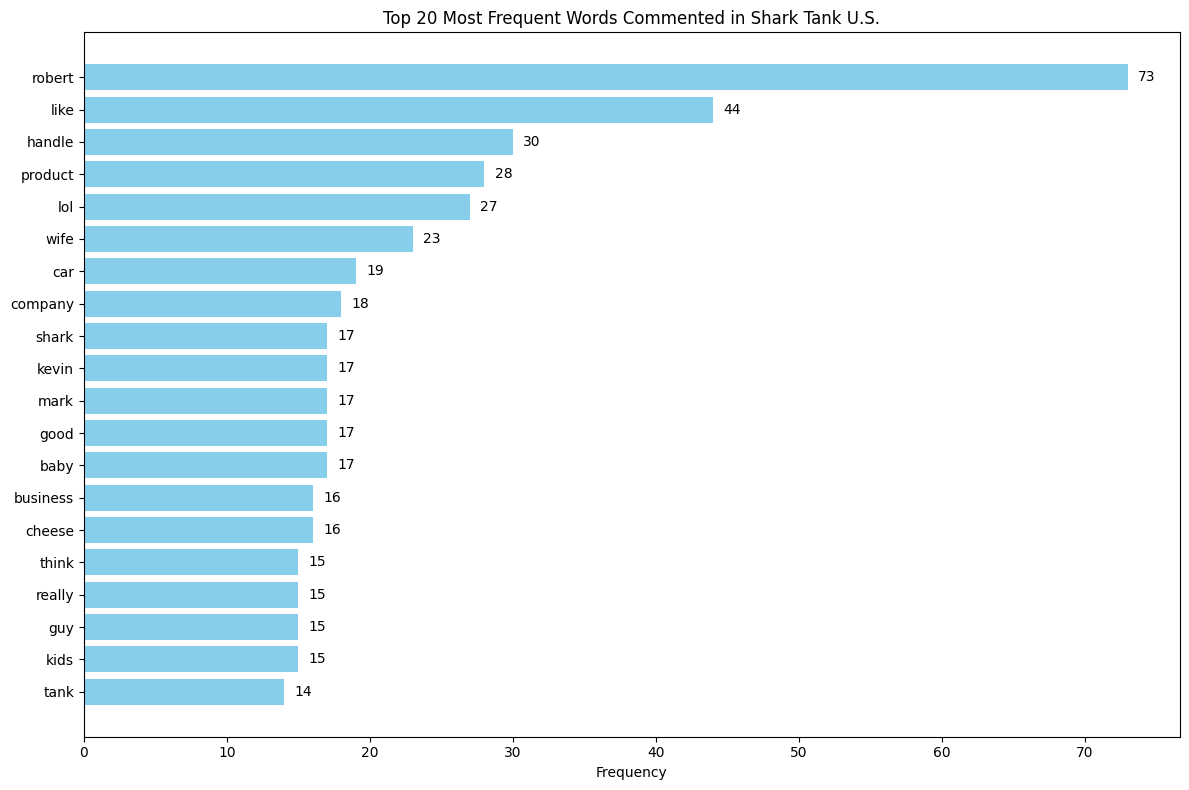

In [ ]:
## TERM FREQUENCY VISUALIZATIONS


for i, (word, count) in enumerate(top_words, 1):
    print(f"{i:2d}. {word:<15} ({count:,} times)")

words = [word for word, count in top_words]
counts = [count for word, count in top_words]

plt.figure(figsize=(12, 8))
plt.barh(range(len(words)), counts, color='skyblue')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title(f'Top {len(words)} Most Frequent Words Commented in Shark Tank U.S.')
plt.gca().invert_yaxis()  # Put highest frequency at top

# Add count labels on bars
for i, count in enumerate(counts):
    plt.text(count + max(counts)*0.01, i, str(count), va='center')

plt.tight_layout()
plt.show()


## SENTIMENT VISUALIZATIONS


🎭 SENTIMENT ANALYSIS SUMMARY
Total entries analyzed: 446
Average sentiment: 0.060
Most positive entry: 0.917
Most negative entry: -0.913
Standard deviation: 0.418

Sentiment distribution:
Positive (>0.1): 157 (35.2%)
Neutral (-0.1 to 0.1): 165 (37.0%)
Negative (<-0.1): 124 (27.8%)
📈 MOST POSITIVE ENTRY (score: 0.917):
Text: the great lines i would like to be reminded of

" do you have a pre-nuptial agreement?

OH~~"

"those toys are my friends
i speak toy"...

📉 MOST NEGATIVE ENTRY (score: -0.913):
Text: Yikes, this company was doomed to fail. Good idea but this lady was very naive in her approach to this. Company went out of business a year after cause they couldn't keep up with demand, pressure from...


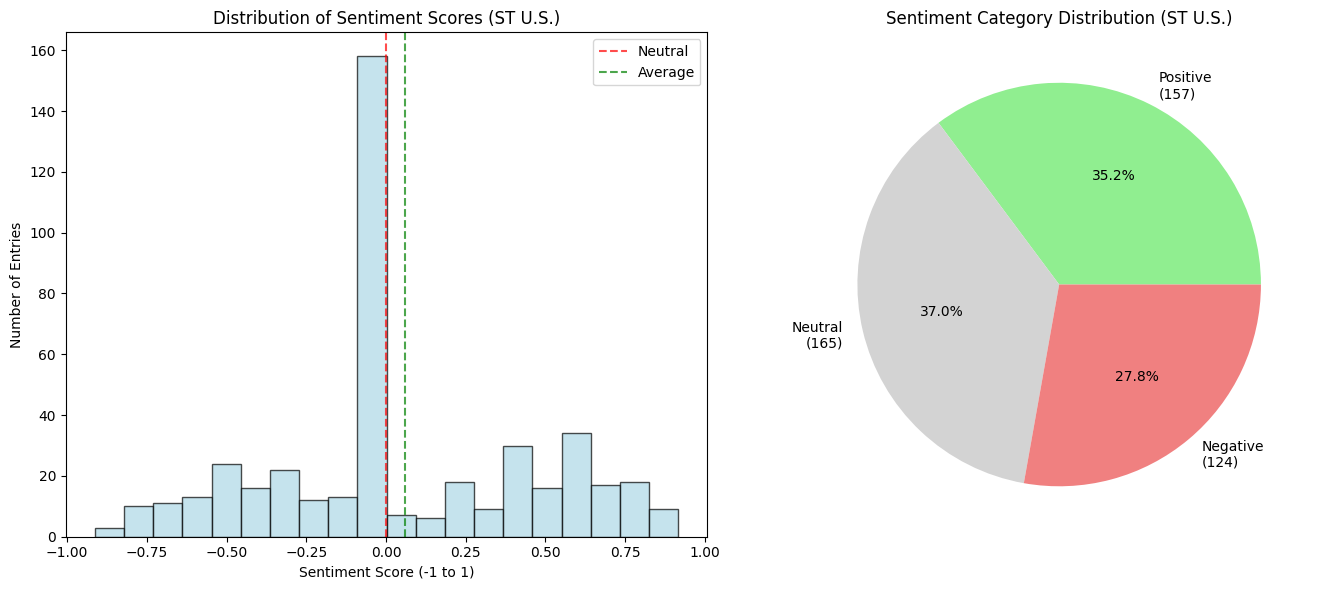

📊 Sentiment visualizations complete!


In [ ]:

# Analyze sentiment patterns in your data
print("🎭 SENTIMENT ANALYSIS SUMMARY")
print("=" * 35)

# Basic statistics
print(f"Total entries analyzed: {len(df)}")
print(f"Average sentiment: {df['sentiment_score'].mean():.3f}")
print(f"Most positive entry: {df['sentiment_score'].max():.3f}")
print(f"Most negative entry: {df['sentiment_score'].min():.3f}")
print(f"Standard deviation: {df['sentiment_score'].std():.3f}")

# Categorize sentiments
positive = len(df[df['sentiment_score'] > 0.1])
neutral = len(df[(df['sentiment_score'] >= -0.1) & (df['sentiment_score'] <= 0.1)])
negative = len(df[df['sentiment_score'] < -0.1])

print(f"\nSentiment distribution:")
print(f"Positive (>0.1): {positive} ({positive/len(df)*100:.1f}%)")
print(f"Neutral (-0.1 to 0.1): {neutral} ({neutral/len(df)*100:.1f}%)")
print(f"Negative (<-0.1): {negative} ({negative/len(df)*100:.1f}%)")

# Find most positive and negative examples
most_positive = df.loc[df['sentiment_score'].idxmax()]
most_negative = df.loc[df['sentiment_score'].idxmin()]

print(f"📈 MOST POSITIVE ENTRY (score: {most_positive['sentiment_score']:.3f}):")
print(f"Text: {most_positive['clean_text_sentiment'][:200]}...")
print()
print(f"📉 MOST NEGATIVE ENTRY (score: {most_negative['sentiment_score']:.3f}):")
print(f"Text: {most_negative['clean_text_sentiment'][:200]}...")

# Create sentiment visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sentiment distribution histogram
axes[0].hist(df['sentiment_score'], bins=20, color='lightblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Sentiment Scores (ST U.S.)')
axes[0].set_xlabel('Sentiment Score (-1 to 1)')
axes[0].set_ylabel('Number of Entries')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.7, label='Neutral')
axes[0].axvline(df['sentiment_score'].mean(), color='green', linestyle='--', alpha=0.7, label='Average')
axes[0].legend()

# Sentiment categories pie chart
sentiment_counts = [positive, neutral, negative]
sentiment_labels = [f'Positive\n({positive})', f'Neutral\n({neutral})', f'Negative\n({negative})']
colors = ['lightgreen', 'lightgray', 'lightcoral']

axes[1].pie(sentiment_counts, labels=sentiment_labels, colors=colors, autopct='%1.1f%%')
axes[1].set_title('Sentiment Category Distribution (ST U.S.)')

plt.tight_layout()
plt.show()

print("📊 Sentiment visualizations complete!")

##TERM FREQUENCY TO SENTIMENT VISUALIZATION


🔍 COMPARING WORDS IN POSITIVE vs. NEGATIVE ENTRIES
Top 10 words in POSITIVE entries (157 entries):
  like            (33 times)
  robert          (23 times)
  lol             (20 times)
  handle          (15 times)
  kevin           (14 times)
  think           (11 times)
  good            (11 times)
  product         (11 times)
  car             (11 times)
  great           (10 times)

Top 10 words in NEGATIVE entries (124 entries):
  robert          (20 times)
  product         (10 times)
  like            (9 times)
  business        (8 times)
  ever            (7 times)
  shark           (7 times)
  bad             (7 times)
  company         (7 times)
  people          (6 times)
  toys            (6 times)


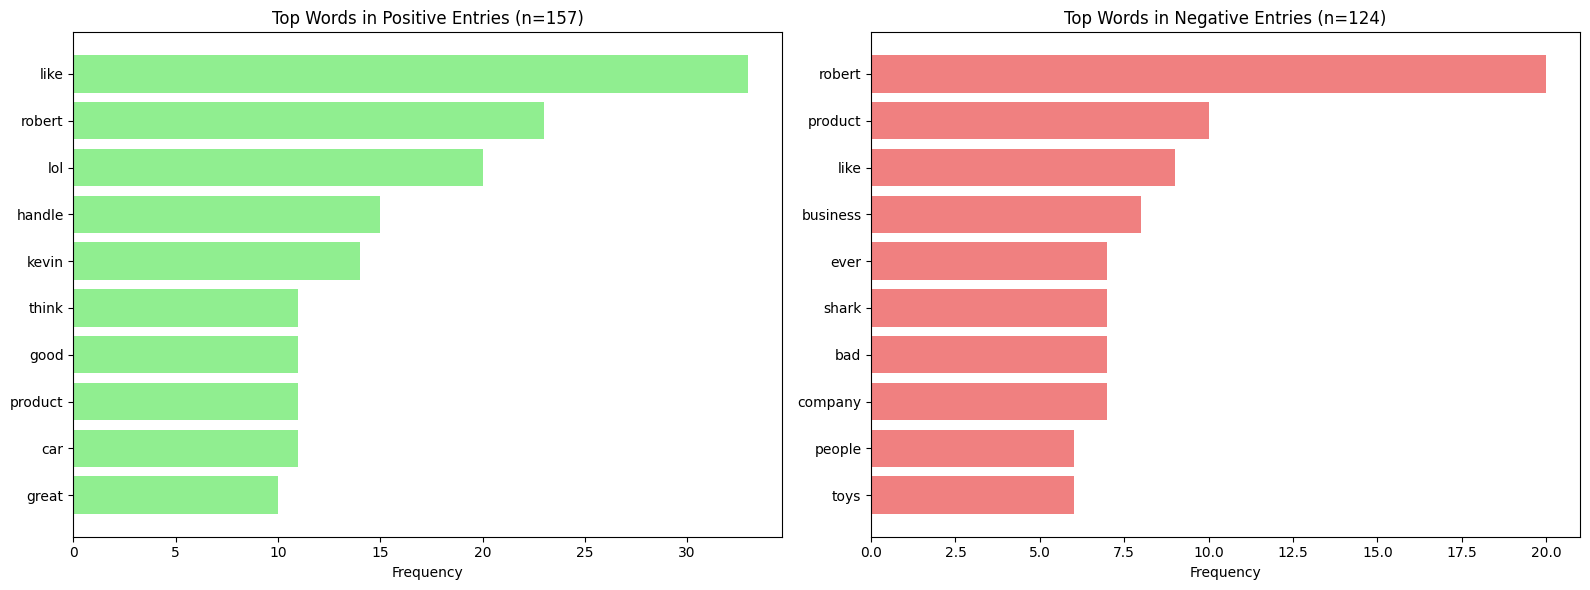

In [ ]:

print("🔍 COMPARING WORDS IN POSITIVE vs. NEGATIVE ENTRIES")
print("=" * 55)

print(f"Top 10 words in POSITIVE entries ({len(positive_entries)} entries):")
for word, count in positive_freq.most_common(10):
    print(f"  {word:<15} ({count} times)")

print(f"\nTop 10 words in NEGATIVE entries ({len(negative_entries)} entries):")
for word, count in negative_freq.most_common(10):
    print(f"  {word:<15} ({count} times)")

    # Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive words
pos_words = [word for word, count in positive_freq.most_common(10)]
pos_counts = [count for word, count in positive_freq.most_common(10)]

axes[0].barh(range(len(pos_words)), pos_counts, color='lightgreen')
axes[0].set_yticks(range(len(pos_words)))
axes[0].set_yticklabels(pos_words)
axes[0].set_title(f'Top Words in Positive Entries (n={len(positive_entries)})')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()

# Negative words
neg_words = [word for word, count in negative_freq.most_common(10)]
neg_counts = [count for word, count in negative_freq.most_common(10)]

axes[1].barh(range(len(neg_words)), neg_counts, color='lightcoral')
axes[1].set_yticks(range(len(neg_words)))
axes[1].set_yticklabels(neg_words)
axes[1].set_title(f'Top Words in Negative Entries (n={len(negative_entries)})')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

##TOPIC MODELING VISUALIZATION


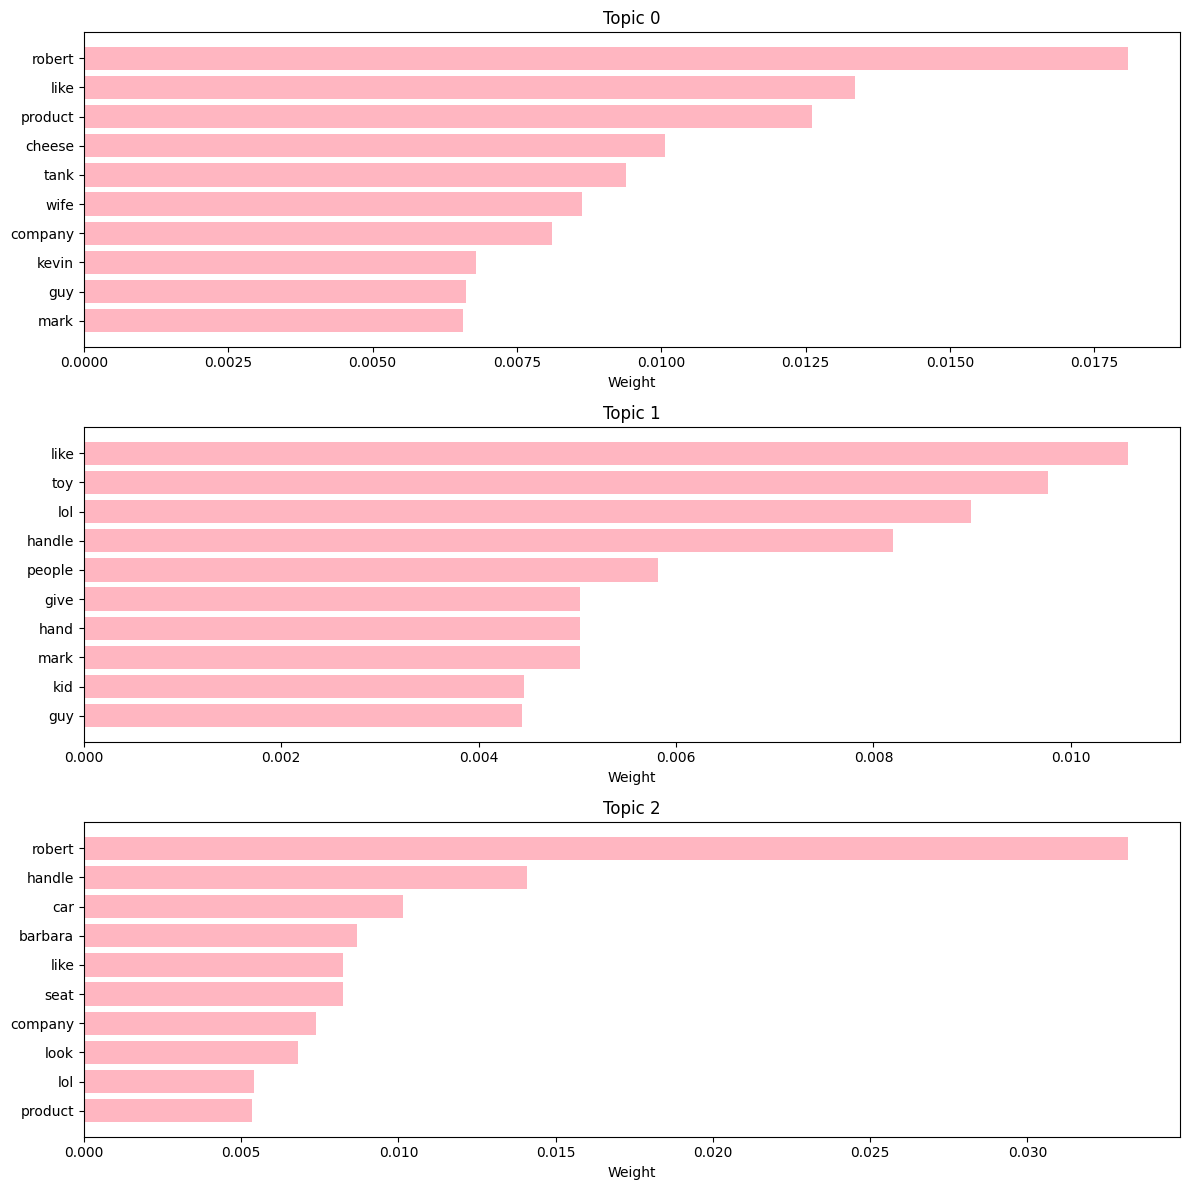

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(num_topics, 1, figsize=(12, 4*num_topics))

if num_topics == 1:
    axes = [axes]

for idx in range(num_topics):
    words_weights = lda_model.show_topic(idx, 10)
    words = [word for word, weight in words_weights]
    weights = [weight for word, weight in words_weights]

    axes[idx].barh(range(len(words)), weights, color='lightpink')
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].set_xlabel('Weight')
    axes[idx].set_title(f'Topic {idx}')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

##SENTIMENT IN TOPIC VISUALIZATION


/tmp/ipython-input-632221523.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(topic_sentiment_data, labels=[f'Topic {i}' for i in range(num_topics)])


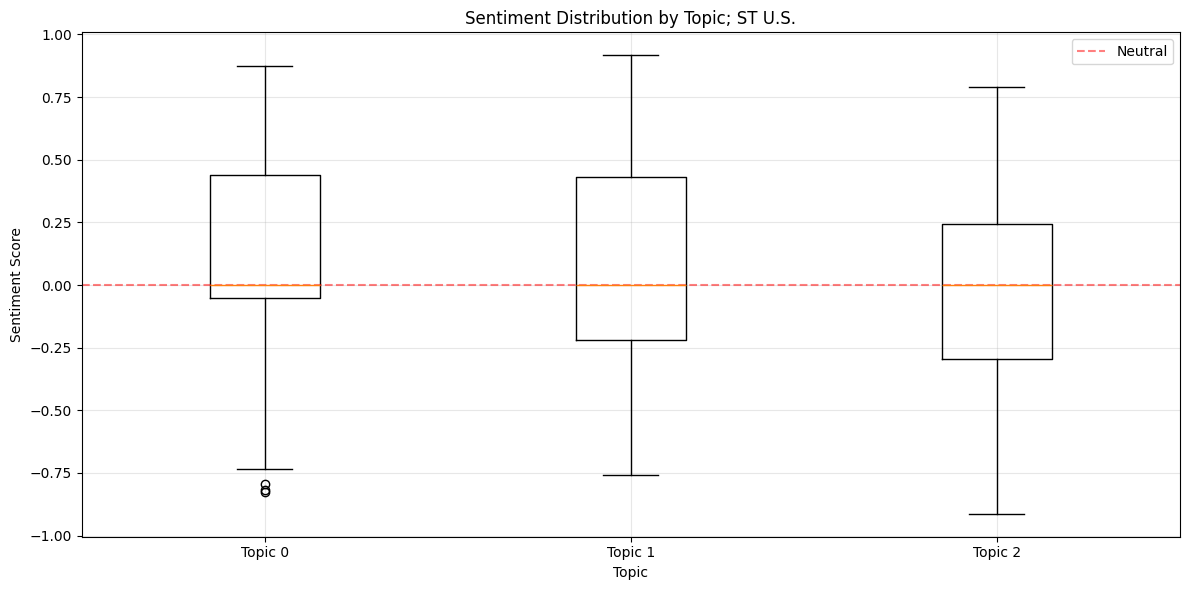

📊 Sentiment by topic visualization complete!


In [ ]:
# Visualize sentiment distribution by topic
fig, ax = plt.subplots(figsize=(12, 6))

# Create box plot of sentiment scores by topic
topic_sentiment_data = [df[df['dominant_topic'] == i]['sentiment_score'].values
                        for i in range(num_topics)]

ax.boxplot(topic_sentiment_data, labels=[f'Topic {i}' for i in range(num_topics)])
ax.set_xlabel('Topic')
ax.set_ylabel('Sentiment Score')
ax.set_title('Sentiment Distribution by Topic; ST U.S.')
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Neutral')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Sentiment by topic visualization complete!")